In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib
font = {'size'   : 16}

matplotlib.rc('font', **font)

# Now let's get the real-world data and try to interpret it

#### What are we conceptually trying to do here? 

#### What are some of the pluses and minuses of this approach?

#### How else could we do this? (Also leave for the later discussion)

### Load the HINODE quiet Sun data and visualize it

In [2]:
obs_stokes = pyana.fzread("/home/milic/data/MiHi/snapi_inv/mihi_630_sf.f0")["data"]

In [3]:
obs_stokes.shape

(121, 135, 4, 200)

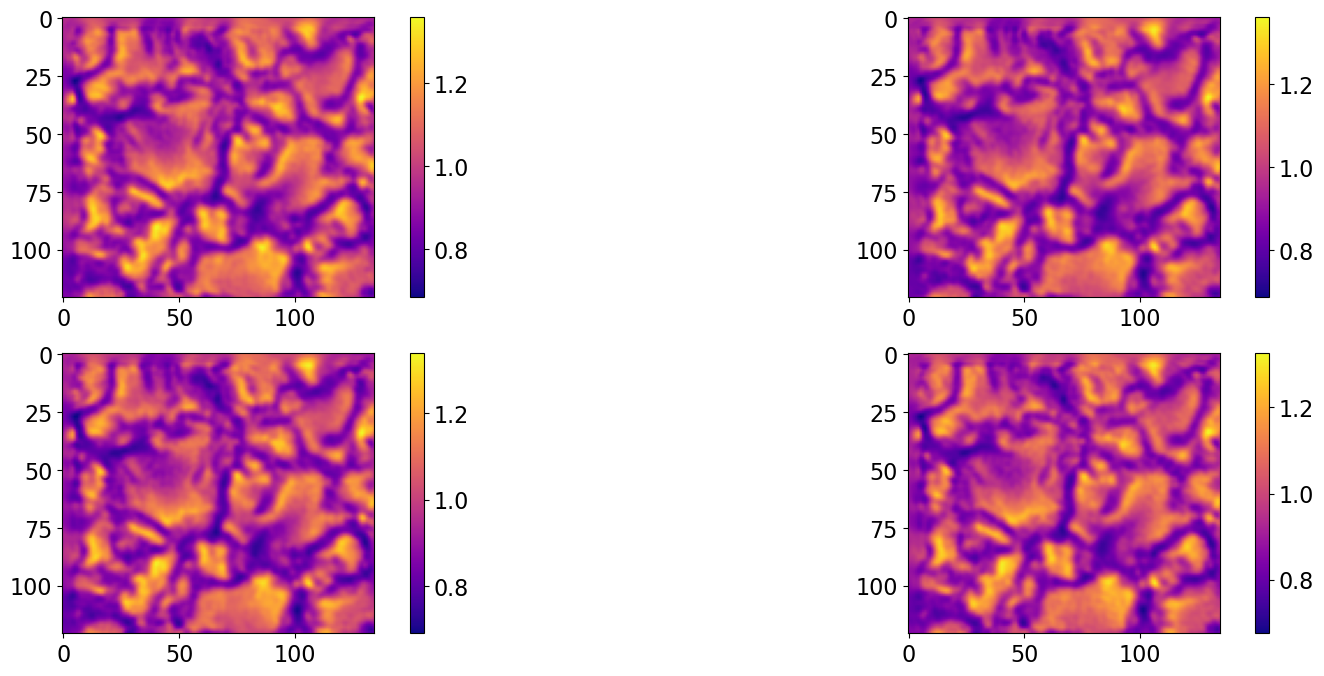

In [4]:
plt.figure(figsize=[20,8])
plt.subplot(221)
plt.imshow(obs_stokes[:,:,0,10],cmap='plasma')
plt.colorbar()
plt.subplot(222)
plt.imshow(obs_stokes[:,:,0,23],cmap='plasma')
plt.colorbar()
plt.subplot(223)
plt.imshow(obs_stokes[:,:,0,26],cmap='plasma')
plt.colorbar()
plt.subplot(224)
plt.imshow(obs_stokes[:,:,0,29],cmap='plasma')
plt.colorbar()

### At the first look, it seems different, that is because this field of view is much larger, let's cut out roughly one - tenth of the field of view

In [5]:
to_fit = np.copy(obs_stokes[:,:,[0,3],:])


In [6]:
to_fit = to_fit.reshape(-1,2*200)

In [7]:
to_fit.shape

(16335, 400)

In [8]:
norms = fits.open("normalized_data_in.fits")[1].data
norms.shape

(2,)

In [9]:
print(norms)

[0.87887165 0.22391241]


In [10]:
to_fit = to_fit / norms[1]
to_fit[:,:200] -= norms[0]/norms[1]
to_fit[:,200:] *= 2.0

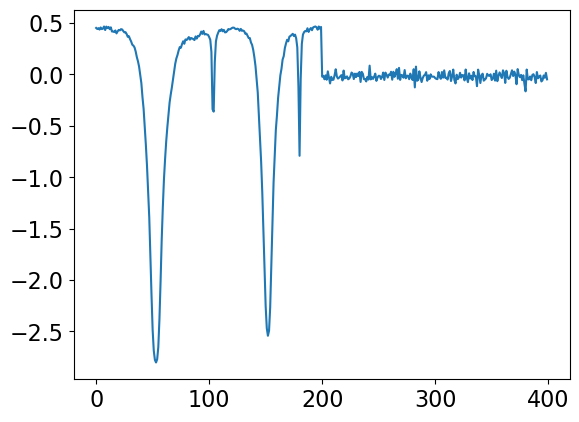

In [11]:
plt.plot(to_fit[114])

In [12]:
to_fit = to_fit.reshape(-1,2,200)

In [13]:
to_fit = torch.from_numpy(to_fit.astype("float32"))

In [14]:
# This is faily simple fully connected, not-so-deep neural network:

# Discuss in moderate detail what each thing does: 


class dnn(nn.Module):
    
    def __init__(self, inputchan, input_wvl, outputsize):
        super(dnn, self).__init__()
        
        inputsize = inputchan * input_wvl
        
        
        self.conv1 = nn.Conv1d(inputchan,4,5,padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv1d(4,4,3,padding=1, padding_mode='replicate')
        
        self.pool = nn.MaxPool1d(2)
        
        self.activationLR = nn.LeakyReLU()
        self.activationS = nn.Sigmoid()
        
        self.linear1 = nn.Linear(inputsize // 4, 32)   
        self.linear2 = nn.Linear(32, outputsize)
        
        self.flat = nn.Flatten()
        
        
    def forward(self, data_in):
        
        x = self.conv1(data_in)
        x = self.pool(x)
        x = self.pool(x)
        x = self.activationLR(x)
        
        x = self.conv2(x)
        x = self.pool(x)
        x = self.activationLR(x)
        
        x = self.flat(x)
        
        x = self.linear1(x)
        x = self.activationLR(x)
        
        x = self.linear2(x)
        return x
    



In [15]:
def make_model(cudaoption, input_chan, input_wvl, outputsize):
    
    model = dnn(input_chan, input_wvl, outputsize)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

## Let's make a function to train:

def compilefit(model, data_in, data_out, data_val_in, data_val_out, nepochs, criterion, cudaoption, lri, output_interval, batch, weight_decayi):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri, weight_decay = weight_decayi)
    loss_fn = nn.MSELoss()
    loss_val_fn = nn.MSELoss()
    
    if cudaoption:
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        data_val_in = data_val_in.to(device)
        data_val_out = data_val_out.to(device)
        
        
    performance = np.zeros([2,nepochs])
                
    for i in range(0,nepochs):
            
        optimizer.zero_grad()
        
        out = model.forward(data_in)
        loss = loss_fn(data_out, out)
        
        loss.backward()
        optimizer.step()
        
        performance[0,i] = loss.item()
        
        # Validation:
        out_val = model.forward(data_val_in)
        loss_val = loss_val_fn(out_val, data_val_out)
        
        performance[1,i] = loss_val.item()
        
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - residual std : {np.sqrt(loss.item()):.6f} - val std : {np.sqrt(loss_val.item()):.6f}')
    return performance

In [16]:
cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0


In [17]:
dnn_model = torch.load("inv_full_mihi.pt",map_location=torch.device('cpu'))

In [18]:
test_output = model_predict(dnn_model,to_fit,cudaoption)

In [19]:
test_output = test_output.detach().numpy()

In [20]:
test_output.shape

(16335, 10)

In [21]:
test_output = test_output.reshape(121,135,-1)

In [22]:
test_output.shape

(121, 135, 10)

In [23]:
T_mean,T_std = fits.open("normalized_data_out.fits")[1].data
vz_mean,vz_std = fits.open("normalized_data_out.fits")[2].data
B_mean,B_std = fits.open("normalized_data_out.fits")[3].data

In [24]:
print (T_mean, T_std)
print (vz_mean, vz_std)
print (B_mean, B_std)

5453.8643 1099.4214
23007.281 137831.95
111.24224 152.1178


In [25]:
# Looks good, now let's return our results to physical units

In [26]:
test_output[:,:,:5] = test_output[:,:,:5] * T_std + T_mean

In [27]:
test_output[:,:,5:8] = test_output[:,:,5:8] * vz_std + vz_mean

In [28]:
test_output[:,:,8] = test_output[:,:,8] * B_std + B_mean

### Exciting, let's plot:

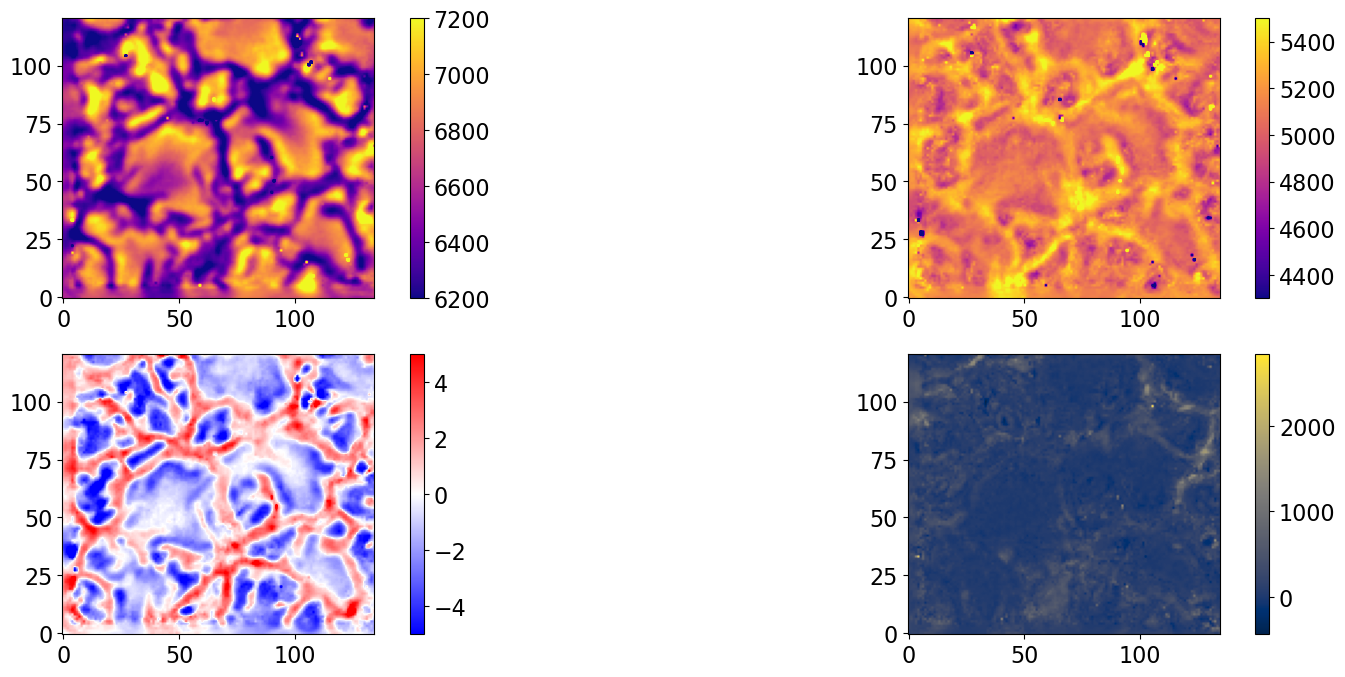

In [29]:
plt.figure(figsize=[20,8])
plt.subplot(221)
plt.imshow(test_output[:,:,4],cmap='plasma',origin='lower',vmin=6200,vmax=7200)
plt.colorbar()
plt.subplot(222)
plt.imshow(test_output[:,:,2],cmap='plasma',origin='lower',vmin=4300,vmax=5500)
plt.colorbar()
plt.subplot(223)
plt.imshow(test_output[:,:,7]/-1E5,cmap='bwr', origin='lower',vmin=-5,vmax=5)
plt.colorbar()
plt.subplot(224)
plt.imshow(test_output[:,:,8],cmap='cividis', origin='lower')
plt.colorbar()

### The results look good at the first glance, but they are a little weird. Any ideas how we can make this better?

### Also why am I saying they are a little weird? 

### Before that, have a look at the velocities...

(array([1.0000e+00, 0.0000e+00, 5.0000e+00, 6.0000e+00, 1.4000e+01,
        1.6296e+04, 8.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-4769.8887, -2669.0154,  -568.1422,  1532.7311,  3633.6042,
         5734.4775,  7835.3506,  9936.224 , 12037.098 , 14137.971 ,
        16238.844 ], dtype=float32),
 <BarContainer object of 10 artists>)

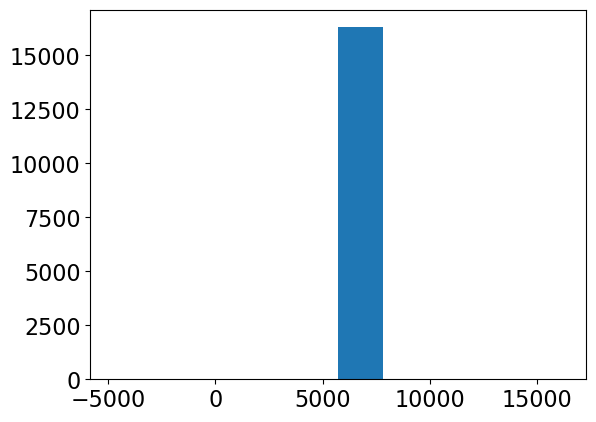

In [30]:
plt.hist(test_output[:,:,4].flatten())

In [31]:
np.amax(test_output[:,:,5])

1259513.2

In [32]:
np.amin(test_output[:,:,5])

-2881682.8

In [33]:
from scipy.ndimage import median_filter

In [36]:
model_output = np.copy(test_output)

In [41]:
for p in range(0,10):
    model_output[:,:,p] = median_filter(test_output[:,:,p],size=5,mode='wrap')

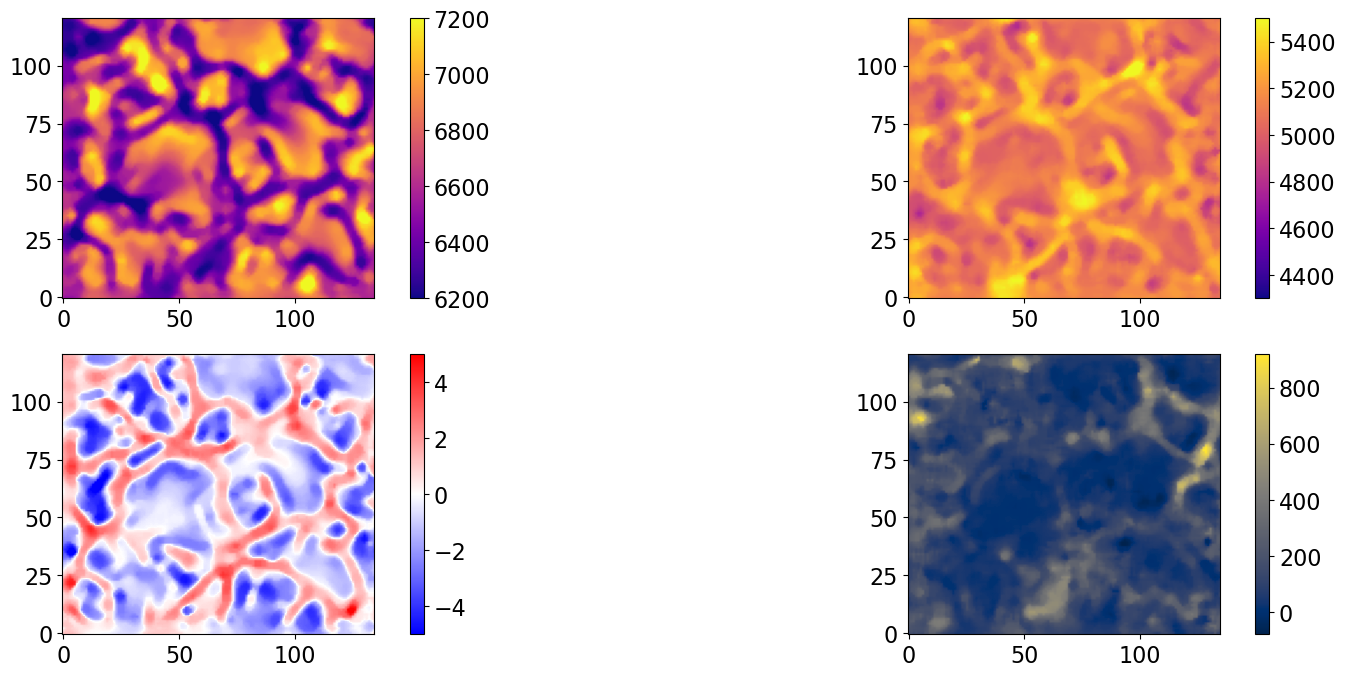

In [58]:
plt.figure(figsize=[20,8])
plt.subplot(221)
plt.imshow(model_output[:,:,4],cmap='plasma',origin='lower',vmin=6200,vmax=7200)
plt.colorbar()
plt.subplot(222)
plt.imshow(model_output[:,:,2],cmap='plasma',origin='lower',vmin=4300,vmax=5500)
plt.colorbar()
plt.subplot(223)
plt.imshow(model_output[:,:,7]/-1E5,cmap='bwr', origin='lower',vmin=-5,vmax=5)
plt.colorbar()
plt.subplot(224)
plt.imshow(model_output[:,:,8],cmap='cividis', origin='lower')
plt.colorbar()

In [43]:
# Make sure the orientation is fine:

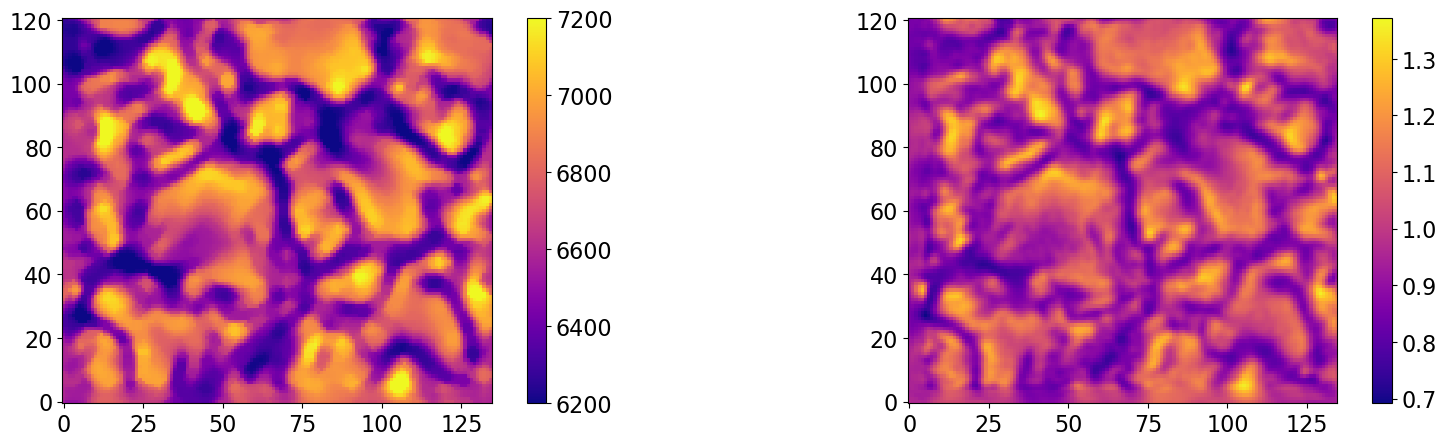

In [46]:
plt.figure(figsize=[20,5])
plt.subplot(121)
plt.imshow(model_output[:,:,4],cmap='plasma',origin='lower',vmin=6200,vmax=7200)
plt.colorbar()
plt.subplot(122)
plt.imshow(obs_stokes[:,:,0,0],cmap='plasma',origin='lower')
plt.colorbar()


In [47]:
test = pyana.fzread("/home/milic/data/MiHi/snapi_inv/inverted_nodes.f0")["data"]

In [48]:
test.shape

(10, 61, 61)

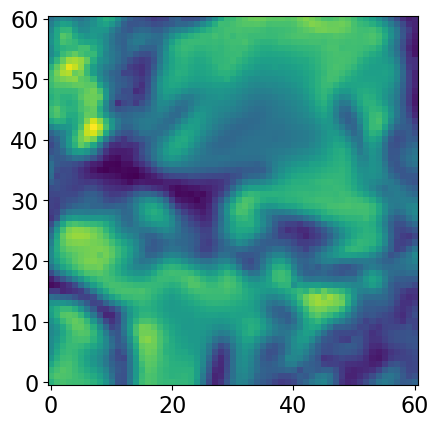

In [51]:
plt.imshow(test[4].T,origin='lower')

In [59]:
model_output = model_output.T

In [60]:
model_output.shape

(10, 135, 121)

In [61]:
model_output[9,:,:] = np.pi / 3.0 

In [62]:
pyana.fzwrite("full_guess.f0",model_output,0,'bla')

1

In [63]:
%pwd 

'/home/milic/codes/SNAPI_init_dnn'